In [26]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sns.set_style('whitegrid')

import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(10,5)})

if not "root" in locals():
    current_path = Path(os.getcwd())
    root = current_path.parent.absolute()
os.chdir(root)

from tools.add_AR_cols import add_AR_cols
from data_treatment.box_creator import create_binary_box
PATH = "../"

In [27]:
df = pd.read_csv('database.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = create_binary_box(df, relative_threshold = 0.05, box_length=5).set_index(['Date']).dropna(axis = 0)
df[['PX_OPEN_VIX_volatility','Box']]
df = add_AR_cols(df,7)

In [28]:
y = df['Box']
X = df.drop(['Box', 'Neutral_SENTIMENT', 'Bull-Bear Spread_SENTIMENT'], axis=1)

prepocessing_pipeline = make_pipeline(SelectKBest(k=40), StandardScaler(), MinMaxScaler(feature_range=(-1,1)))

In [29]:
X = prepocessing_pipeline.fit_transform(X,y)

cols = prepocessing_pipeline.named_steps['selectkbest'].get_feature_names_out()

X = pd.DataFrame(data=X, columns=cols)

In [30]:
coeffs_list =[]
c_s = np.geomspace(1,1e8,100)

lasso = LogisticRegression(C=1/c_s[0], fit_intercept=True, penalty='l1', solver='saga')
lasso.fit(X,y)
coeffs_list.append(lasso.coef_[0])

X =X [np.array(X.columns)[coeffs_list[0]!=0]]

tab_coeff = np.empty([len(c_s)-1,len(X.columns)])

c_s = c_s[1:]

for i in range(len(c_s)):
    lasso = LogisticRegression(C=1/c_s[i], fit_intercept=True, penalty='l1', solver='liblinear')
    lasso.fit(X,y)
    tab_coeff[i,:]= lasso.coef_[0]

In [38]:
coeff_df = pd.DataFrame(data=tab_coeff[::-1], index=c_s[::-1], columns=X.columns)
coeff_df["Valid cols"] = coeff_df[coeff_df!=0].count(axis=1)

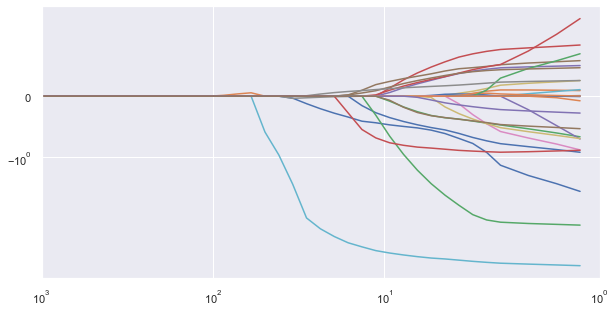

In [39]:
plot = coeff_df.drop("Valid cols", axis=1).plot(legend= False, logx='sym', logy='sym',xlim = [1e3, 1])
plt.show()

In [40]:
first_cols = coeff_df[coeff_df['Valid cols']==15][coeff_df!=0].dropna(axis=1).columns

plot = coeff_df[first_cols].drop("Valid cols", axis=1)
plt.show()

In [41]:
plot


,PX_OPEN_VIX_volatility,VOLUME_TOTAL_CALL_VIX_volatility,PUT_CALL_VOLUME_RATIO_CUR_DAY_VIX_volatility,3MTH_IMPVOL_105.0%MNY_DF_VIX_volatility,PUT_CALL_VOLUME_RATIO_CUR_DAY_SPX_volatility,TOT_OPT_VOLUME_CUR_DAY_SPX_volatility,VOLATILITY_260D_SPX_volatility,VOLATILITY_360D_SPX_volatility,VOLATILITY_180D_SPX_volatility,PUT_CALL_VOLUME_RATIO_CUR_DAY_SX5E_volatility,...,BAB USA_BAB Factors,Bullish 8-week Mov Avg_SENTIMENT,ST_Rev_F-F_ST_Reversal_Factor_daily,Mkt-RF_F-F_Research_Data_5_Factors_2x3_daily,SMB_F-F_Research_Data_5_Factors_2x3_daily,RMW_F-F_Research_Data_5_Factors_2x3_daily,VIX_LAG_1,VIX_LAG_3,VIX_LAG_4,VIX_LAG_5
1.000000e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8.302176e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6.892612e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5.722368e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4.750810e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.535364e+00,-0.919047,0.081713,-0.440798,0.732735,0.440385,0.486801,0.0,0.000000,0.125450,0.000000,...,-0.451289,0.212799,-0.449566,-5.002346,-0.730208,0.000000,-2.061383,-0.907917,-0.197656,-0.431792
2.104904e+00,-1.128977,0.101849,-0.470421,0.763193,0.463629,0.514369,0.0,0.000000,0.179550,0.000000,...,-0.577787,0.229509,-0.514494,-5.092231,-0.776525,0.000000,-2.160093,-0.916175,-0.219500,-0.463975
1.747528e+00,-1.296499,0.101549,-0.533393,0.789587,0.479165,0.541853,0.0,0.000000,0.210939,0.040510,...,-0.683789,0.240405,-0.580568,-5.189976,-0.825382,0.000000,-2.219533,-0.907947,-0.241711,-0.489680
1.450829e+00,-1.431030,0.097057,-0.601680,0.813976,0.490990,0.563251,0.0,0.001828,0.234697,0.077238,...,-0.782718,0.248776,-0.640931,-5.282578,-0.872872,-0.025225,-2.260785,-0.895373,-0.261078,-0.511583


In [42]:
import plotly.express as px
fig = px.line(plot, x=plot.index, y=plot.columns,range_x=[1e2, 1], log_x=True)
with open("analysis/lasso_selection_graph_g0b.html", "w") as f:
    f.write(fig.to_html())

